In [ ]:
# default_exp network_class

# Network Class

> Culmination of `Graph Functions` and `Model Functions` pages into a single `Network` class object, which contains the previous functions and a pipeline for generating and simulating complex networks with dynamics.

In [ ]:
#hide
from nbdev import *
from nbdev.imports import *
from nbdev.export import *
from nbdev.sync import *
from nbdev.showdoc import *

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import warnings
with warnings.catch_warnings(): #ignore warnings
    warnings.simplefilter("ignore")
    import networkx as nx
    import numpy as np
    import sidis
    rng=sidis.RNG(0)
    import matplotlib.pyplot as plt
    import typing
    from typing import Optional, Tuple, Dict, Callable, Union, Mapping, Sequence, Iterable, Hashable, List, Any
    from collections import namedtuple
    
    from networkm.graph_functions import *
    from networkm.model_functions import *

Warming up integrator; future calls will be accelerated.
bool_integral : Elapsed time: 2.9628 seconds
bool_integral_risefall : Elapsed time: 0.0000 seconds


In [ ]:
#export
class BooleanNetwork(nx.MultiDiGraph):
    '''
    Generic network model class. Has base functionality for incorporating
    a network and simulating its dynamics, as well as executing arbitrary 
    routines. Can pass a network `g`, `node_data`, `edge_data`, and `kwargs`
    which get placed as attributes. `routines` is a list of functions,
    args, kwargs, and optional string attributes, which specify a list
    of functions to execute over the args and kwargs, and whether to set
    the result as an attribute of the model. This allows for arbitrary
    executions of routines. Finally, `derivative`, `integrator`, and
    `visualizer` specify the state-change and plotting functions.
    
    Parameters:
        g : incoming graph data
        node_data : dict containing
            a : node sigmoid parameter, use np.inf for rounding
            tau : node time constant, use scalar for single time constant,
                or tuple (rise,fall) for rise and fall behavior
            f : node boolean function
        edge_data : dict containing
            delay : time-delay along the given edge
            replace : None for no edge replacement,
                or a dict containing node attributes of the new 
                nodes replacing that edge
        T : integration time
        dt : integration timestep
        epsilon : noise amplitude for positive-definite uniformly random
    '''
    def __init__(self,
                 g = ring(N=16,left=True,right=True,loop=True),

                 a = (rng.normal,20,0),
                 tau = (rng.normal,0.5,0),
                 f = XOR,

                 delay = (rng.normal,0,0),

                 edge_replacements = dict(
                     lengths = 1,
                     delay = (rng.normal,0,0),
                     node_attrs = dict(
                         a = (rng.normal,20,0),
                         tau = (rng.normal,0.2,0),
                         f = MPX
                     ),
                     label = lambda g,node,iterable : len(g)+iterable
                 ),
                 
                 T = 15,
                 dt = 0.01,
                 noise = 0,
                 init = None,
                 hold = None,
                 steady = True,
                 view = 'out',
                 plot = True
                ):
        
        #super init
        super().__init__(g)
        self.view(view)
        self.setup(a=a,tau=tau,f=f,delay=delay,edge_replacements=edge_replacements,
                   T=T,dt=dt,noise=noise,steady=steady,init=init,hold=hold,plot=plot)
        

    
    def setup(self,a,tau,f,delay,edge_replacements,T,dt,noise,steady,init,hold,plot):
        self.give_nodes(a=a,tau=tau,f=f)
        self.give_edges(delay=delay)
        if edge_replacements:
            convert_edges(self,edges=edge_replacements.get('edges'),
                               lengths=edge_replacements.get('lengths'),
                               node_data=edge_replacements.get('node_attrs'),
                               delay=edge_replacements.get('delay'))
        self.sort()
        self.itr=bool_model_iter(self)
        self.dt=dt
        self.T=int(T/dt)
        self.node_data(save=True)
        self.edge_data(save=True)
        self.init,self.hold=bool_initial_conditions(self,init=init,hold=hold,steady=steady)
        self.hold=(self.hold/dt).astype(np.int64)
        self.delay=(self.delay/dt).astype(np.int64)
        self.predar=np.concatenate([list(self.predecessors(n)) 
                                    for n in self.nodes]).astype(np.int64)
        self.noise=rng.random(0,noise,absval=True,shape=(self.T,len(self))).astype(np.float64)
        if len(self.tau.shape)!=1:
            self.integral=bool_integral_risefall
        else:
            self.integral=bool_integral
        self.integrate(init=self.init,hold=self.hold)
        
        if plot:
            self.plot()
        
        
    def integrate(self,init=None,hold=None):
        if init is None and hold is None:
            self.init,self.hold=bool_initial_conditions(self,init,hold)
            self.hold=(self.hold/dt).astype(np.int64)
        self.x=self.integral(iterator=self.itr,
                          time_delays=self.delay,
                          sigmoid_constants=self.a,
                          time_constants=self.tau,
                          predecessors=self.predar,
                          noise=self.noise,
                          initial_conditions=self.init,
                          hold_times=self.hold,
                          dt=self.dt)
    
    def view(self,view='in'):
        '''
        Change default edge view
        '''
        if view=='in':
            self.edge_view=nx.classes.reportviews.InMultiEdgeView

        elif view=='out':
            self.edge_view=nx.classes.reportviews.OutMultiEdgeView
            
    
    @nx.MultiDiGraph.edges.getter
    def edges(self):
        return self.edge_view(self)
    
    
    def sort(self,**kwargs):
        sort_graph(self,**kwargs)
        

    def relabel(self,mapping=None):
        relabel_graph(self,mapping)
        

    def node_attrs(self):
        return node_attrs(self)
    

    def edge_attrs(self):
        return edge_attrs(self)
    

    def give_nodes(self,data=None,nodes=None,**kwargs):
        give_nodes(self,data=data,nodes=nodes,**kwargs)
            

    def give_edges(self,data=None,edges=None,**kwargs):
        give_edges(self,data=data,edges=edges,**kwargs)

    def give_self(self,data=None,**kwargs):
        '''
        Give any arg dict and kwargs to self as attrs
        '''
        try:
            sidis.give(self,**parse_kwargs(**kwargs))
        except:
            pass

        if data:
            for k,v in data.items():
                try:
                    self.__dict__.update(parse_kwargs(**v))
                except KeyError:
                    pass
            
            
    def clear_nodes(self,*args):
        '''
        Remove arg entries from node dict
        '''
        if not args:
            args=self.node_attrs()
        [[sidis.give(self.node[n],arg,None) for n in self.nodes] for arg in args]
        
    
    def clear_edges(self,*args):
        '''
        Remove arg entries from edge dict
        '''
        if not args:
            args=self.edge_attrs()
        [[sidis.give(self.edges[e],arg,None) for e in self.edges] for arg in args]
        

    def node_data(self,*args,save=False):
        '''
        Set node attributes as self attribute array. 
        '''
        if not save:
            return node_data(self,*args)
        else:
            self.give_self(**node_data(self,*args))


    def edge_data(self,*args,save=False):        
        if not save:
            return edge_data(self,*args)
        else:
            self.give_self(**edge_data(self,*args))
                
                    
    def replace_edges(self,
                      edges : Union[None,tuple,List[tuple]] = None,
                      lengths : Union[str,int,dict] = 1,
                      node_data : dict = {},
                      label : callable = lambda g,node,iterable : len(g)+iterable,
                      **edge_data):
        
        if label is None:
            label = lambda g,node,iterable : len(g)+iterable
        if lengths is None:
            lengths=1
            
        convert_edges(self,edges=edges,lengths=lengths,node_data=node_data,label=label,
                      **edge_data)
        
        
    def where(self,*args,**kwargs):
        return where(self,*args,**kwargs)
    
    def edgewhere(self,*args):
        return np.array(self.edges)[self.where(*args)]
    
    def nodewhere(self,*args):
        return np.array(self.nodes)[self.where(*args)]
    
    def __str__(self):
        return print_graph(self,string=True)
    
    def __repr__(self):
        s=str(self)
        S=super().__repr__()
        spl=s.split('\n')
        if len(spl)>10:
            spl=spl[:5]+['...']+spl[-5:]
        return S+'\n'+('\n').join(spl)

    def plot(self):
        '''
        Make separate plots of the node states `x` for each in-degree grouping.
        '''
        self.node_funcs={n:self.nodes[n]['f'] for n in self.nodes}
        funcs=nx.utils.groups(sidis.cast(self.node_funcs,dict))
        funcs={k:list(v) for k,v in funcs.items()}
        for f,nodes in funcs.items():
            for i in nodes:
                plt.plot(np.arange(self.x.shape[0])*self.dt,self.x[:,i])
                title=f'{f.__name__} Nodes: {nodes[0]} to {nodes[-1]}'
                plt.title(title)
                plt.xlabel('Time (ns)')
                plt.ylabel('Amplitude')
            plt.show()
        

bool_integral : Elapsed time: 0.0089 seconds


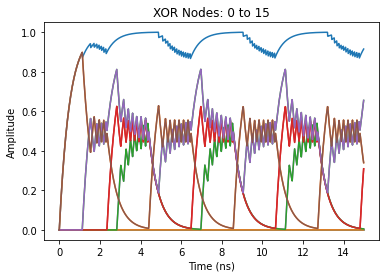

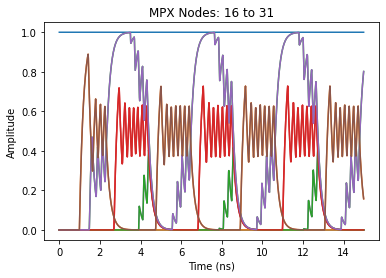

In [ ]:
m=BooleanNetwork(g = ring(N=16,left=True,right=True,loop=True),

                 a = (rng.normal,20,0),
                 tau = (rng.normal,0.5,0),
                 f = XOR,

                 delay = (rng.normal,0,0),

                 edge_replacements = dict(
                     lengths = 1,
                     delay = (rng.normal,0,0),
                     node_attrs = dict(
                         a = (rng.normal,20,0),
                         tau = (rng.normal,0.2,0),
                         f = MPX
                     ),
                     label = lambda g,node,iterable : len(g)+iterable
                 ),
                 
                 T = 15,
                 dt = 0.01,
                 noise = 0,
                 init = None,
                 hold = None,
                 steady = True,
                 view = 'out',
                 plot = True
                 
                )

bool_integral : Elapsed time: 0.0054 seconds


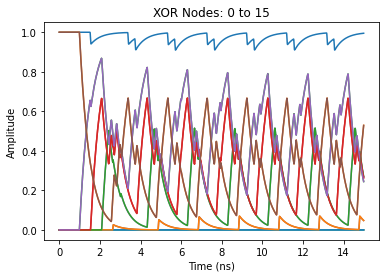

In [ ]:
m=BooleanNetwork(g = ring(N=16,left=True,right=True,loop=True),

                 a = (rng.normal,20,0),
                 tau = (rng.normal,0.5,0),
                 f = XOR,

                 delay = (rng.normal,0.2,0),

                 edge_replacements = None,
                 
                 T = 15,
                 dt = 0.01,
                 noise = 0,
                 init = None,
                 hold = None,
                 steady = True,
                 view = 'out',
                 plot = True
                 
                )

bool_integral_risefall : Elapsed time: 0.1736 seconds


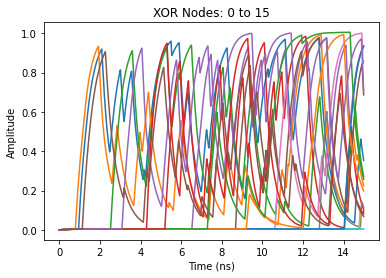

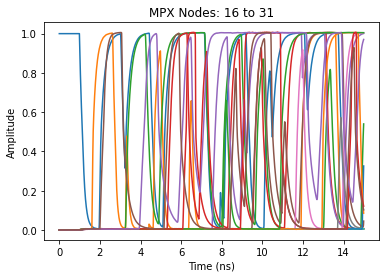

In [ ]:
m=BooleanNetwork(g = ring(N=16,right=True,left=True,loop=True),

          a = (rng.normal,15,5),
          tau = (rng.normal,[0.5,0.4],[0.1,0.05]),
          f = XOR,
          

          delay = (rng.normal,1,0.1),

          edge_replacements = dict(
              lengths = 1,
              delay = (rng.normal,0.5,0.1),
              node_attrs = dict(
                  a = (rng.normal,15,5),
                  tau = (rng.normal,[0.2,0.15],[0.05,0.05]),
                  f = MPX
              ),
              label = lambda g,node,iterable : len(g)+iterable
          ),

          T = 15,
          dt = 0.01,
          noise = 0.01,
          init = None,
          hold = None,
          
          plot=True,
          view='in'
         )

In [ ]:
m

|Node|Predecessors|Successors|
|0   |16, 17, 31  |16        |
|1   |16, 17, 18  |17        |
|2   |17, 18, 19  |18        |
|3   |18, 19, 20  |19        |
...
|28  |12          |11, 12, 13|
|29  |13          |12, 13, 14|
|30  |14          |13, 14, 15|
|31  |15          |0, 14, 15 |

In [ ]:
sidis.refresh()